In [238]:
import environment
from train import initial_train, train_DYNA_agent, train_adaptive_replay
from analysis import compress_replays, calculate_mood
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

plt.rcParams.update({'font.size': 6})



In [239]:
def plot_grid(i,ax):

    ax.set_ylim(ymin,ymax)
    ax.set_xticks([])
    ax.set_yticks([])

    if plot_qs:
        for j in range(len(actions)):
            ax.plot(xi,np.array(qci)[:,i,j],c=cols[j],alpha=1,ls='--',linewidth=2,dashes=(2,1.5+0.25*j));
            ax.plot(x,np.array(qc)[:,i,j],c=cols[j],alpha=1,linewidth=2);
            ax.axvline(len(qci)+grid_search['pre_grieve'],-100,100,c='grey',ls='-',alpha=1,linewidth=1,dashes=(15,5))
            if grid_search['pre_grieve'] > 0:
                ax.axvline(len(qci)+tm.flatten()[i],-100,100,c='red' if tm.flatten()[i]==0 else 'green',ls='-',alpha=1,linewidth=1,dashes=(15,5))
            if i == 0: ax.set_yticks([int(0),np.round(ymax,-1)])


    if int(tm.flatten()[i]) != 0:
        ax.set_facecolor(cmap[int(tm.flatten()[i])])
    else:
        hatch(ax)
        ax.set_ylim(ymin,ymax)


    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1)  # change width

def hatch(ax):
    # Get the limits of the current plot
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # Fill the entire subplot area with hatching
    # Here we use "/' as the hatch pattern
    ax.fill_between(xlim, ylim[0], ylim[1], color='none', hatch='//', edgecolor='grey', zorder=-1, alpha=0.3) 
    # Optionally, adjust the limits back to their original values in case they changed
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)


8 0.5
-1.0 56.503138023164375


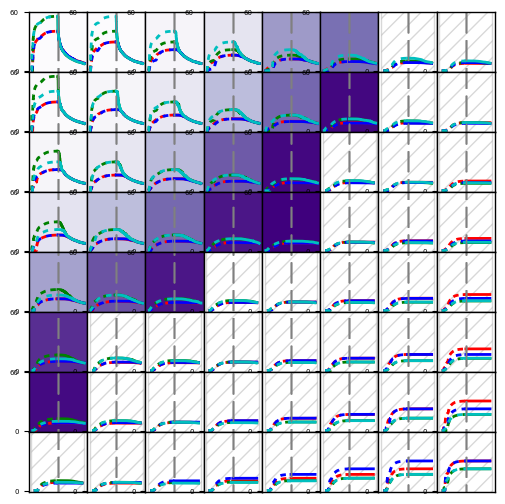

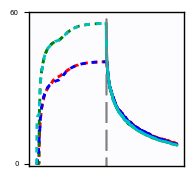

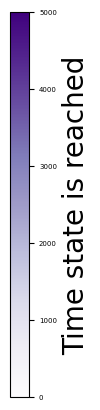

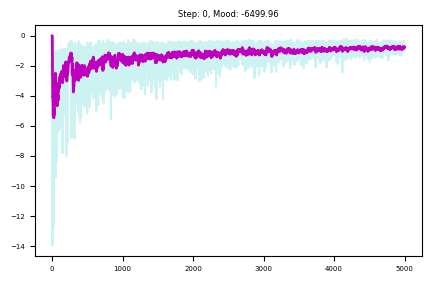

In [247]:

# world = environment.grid(15,10)
# dude = environment.agent(world)
# grid_sizes = [6,8,10,12,14,16,18]
# ws = [0,0.1,0.2]
grid_sizes = [8]
ws = [0.5]
rews = np.zeros((len(grid_sizes),len(ws)))
loss_reward = 0
plotting = True
plot_qs = True
se = 0


for k in range(len(grid_sizes)):
    for m in range(len(ws)):
        print(grid_sizes[k],ws[m])
        grid_size = grid_sizes[k]
        # steps = grid_sizes[k]**2*110
        # steps = 1000
        steps = 5000
        # stepsREP = grid_sizes[k]**2*110
        stepsDYNA = 5000
        replays_init = 64
        # replays = 10
        eps = 40

        reward_dist = {
            (0,0): 10,      # Starting point with a reward of 10
            # (int(k/2),int(k/2)): 15,     # Center of the grid
            # (12,4): 20,     # Center of the grid
            # (2,3): 20,     # Center of the grid
            (-1,-1): 5,     # Ending point with a reward of 5
        }
        states_to_lose = [0]
        lose = [list(reward_dist.keys())[state] for state in states_to_lose]

        grid_search = {
            'w': ws[m],
            'object_value': -10,
            'replays': 5,
            'alpha': 0.1,
            'pain': 0,
            'gamma': 0.95,
            'final_epsilon': 0,
            'ep_anneal': 1,
            'p': 0.1,
            'update': "Q-learning",
            'sampling': "random",
            'loss_reward': loss_reward,
            'happiness': [1,0,0,0],
            'stop_grief': 1000,
            'pre_grieve': 0,
        }

        stepsDYNA = stepsDYNA + grid_search['pre_grieve']


        qs_init, model_init, qci = initial_train(reward_dist, replays=replays_init,gamma=grid_search['gamma'], 
                                                w=grid_search['w'], object_value = grid_search['object_value'],
                                                grid_size = grid_size, steps = steps, happiness = grid_search['happiness'],
                                                se=se,update=grid_search['update'],sampling=grid_search['sampling'])


        rew, pred, course, rep, qc, tm = train_DYNA_agent(reward_dist,lose,grid_size = grid_size, steps=stepsDYNA, 
                                                    starting_qs = qs_init, model = model_init, plotting = False,
                                                    temp=1,se=se,**grid_search)

        # rew, pred, course, rep, qc, tm = train_adaptive_replay(reward_dist, lose, grid_size = grid_size, steps = stepsREP, 
        #                   starting_qs = qs_init, model = model_init, plotting = False,  
        #                   temp=1, episodes = eps, stop_grief = 10000, **grid_search)


        rews[k,m] = rew/(5*stepsDYNA)
        stepcol='Purples'

        cmap = plt.colormaps[stepcol] 
        cmap=cmap(np.linspace(0,1,stepsDYNA))

        actions = ['↓','↑','→','←'] # 0 is down, 1 is up, 2 is right, 3 is left
        xi = range(len(qci))
        x = range(len(qci),len(qci)+len(qc))
        ymin,ymax = np.min(qc+qci)-1, np.max(qc+qci)+1
        # ymin,ymax = -120, 200
        print(ymin,ymax)
        # ymin = 140

        cols = ['r','g','b','c','k']
        gap = int((len(qci)+len(qc))/4)
        # figures
        if plotting:
            fig, axes = plt.subplots(grid_size,grid_size,figsize=(5,5))
            for i, ax in enumerate(axes.flat):
                plot_grid(i,ax)
                # for j in range(len(actions)):
                #     ax.plot(xi,np.array(qci)[:,i,j],c=cols[j],alpha=1,ls='--',linewidth=2,dashes=(2,1.5+0.25*j));
                #     ax.plot(x,np.array(qc)[:,i,j],c=cols[j],alpha=1,linewidth=2);
                # # put a vertical line when the state is first reached in array tm

                #     # if i == 7: 
                #         # ax.scatter(5000*(j+1),20,s=100,marker=f'${actions[j]}$',c=cols[j],zorder=10)
                # # tm[tm==0] = stepsDYNA-1

                # ax.axvline(len(qci)+grid_search['pre_grieve'],-100,100,c='grey',ls='-',alpha=1,linewidth=1,dashes=(15,5))
                # ax.axvline(len(qci)+tm.flatten()[i],-100,100,c='red' if tm.flatten()[i]==0 else 'green',ls='-',alpha=1,linewidth=1,dashes=(15,5))

                # ax.set_ylim(ymin,ymax)
                # ax.set_xticks([])
                # ax.set_yticks([])

                # if int(tm.flatten()[i]) != 0:
                #     ax.set_facecolor(cmap[int(tm.flatten()[i])])

                # for axis in ['top', 'bottom', 'left', 'right']:
                #     ax.spines[axis].set_linewidth(1)  # change width
            # plt.title(f'grid_size: {grid_sizes[k]}, W: {ws[m]}')
            fig.tight_layout()
            plt.subplots_adjust(wspace=0, hspace=0)

            # zoomed into the first state
            plt.rcParams.update({'font.size': 10})
            plot_qs = True
            fig,ax = plt.subplots(1,1,figsize=(2,2))
            plot_grid(0,ax)

            # Create the ScalarMappable and add the colorbar
            fig, axes = plt.subplots(figsize=(5,5))
            plt.gca().set_visible(False)
            norm = Normalize(vmin=0, vmax=stepsDYNA)
            smappable = cm.ScalarMappable(cmap=plt.colormaps[stepcol] , norm=norm)
            smappable.set_array([])
            a = fig.colorbar(smappable, ax = axes, orientation='vertical')
            a.set_label('Time state is reached',fontsize=20)


            # axes.flat[-1].text(7000,-160,f'{int(tm[lose[-1]])}',horizontalalignment='center', verticalalignment='center');
            # print(int(tm[-1,-1]))

            fig,ax = plt.subplots(1,1,figsize=(5,3))
            trace = compress_replays(pred, rep, replay_weight=0.5)
            mood = calculate_mood(trace,0.1)
            ax.plot(trace, 'c',alpha=0.2,label='$\delta$')
            ax.plot(mood,'m',linewidth=2,label='Mood')
            pre=grid_search['pre_grieve']
            ax.set_title(f'Step: {int(tm[-1,-1]) - pre}, Mood: {np.round(sum(mood),2)}')
            # ax[1].plot(course)
            # ax[1].set_title(f'{sum(course)}')


# plt.plot(rews)

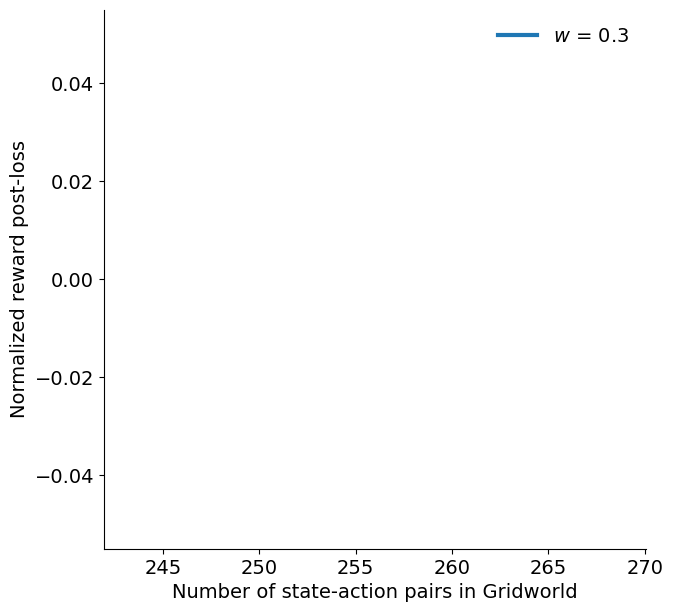

In [182]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(7,7))


ax.plot([4*x**2 for x in grid_sizes],rews,linewidth = 3)
ax.legend([f'$w$ = {x}' for x in ws],frameon=False)
ax.set_xlabel('Number of state-action pairs in Gridworld')
ax.set_ylabel('Normalized reward post-loss')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

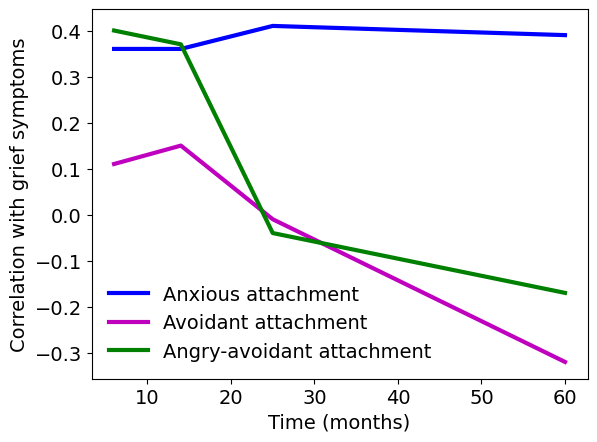

In [43]:
time_points = [6,14,25,60]
symptoms_anxious = [0.36,0.36,0.41,0.39]
symptoms_avoidant = [0.11,0.15,-0.01,-0.32]
symptoms_angry = [0.4,0.37,-0.04,-0.17]

plt.plot(time_points,symptoms_anxious,'b',linewidth=3,label = 'Anxious attachment')
plt.plot(time_points,symptoms_avoidant, 'm',linewidth=3,label = 'Avoidant attachment')
plt.plot(time_points,symptoms_angry, linewidth=3,label = "Angry-avoidant attachment",color='g')
plt.xlabel('Time (months)')
plt.ylabel('Correlation with grief symptoms')
plt.legend(frameon=0)



In [48]:
def optimize(grief_vector):
    rews = np.zeros((len(grid_sizes),len(ws)))
    loss_reward = 0
    plotting = False
    grid_size = 4
    steps = grid_size**2*110
    stepsDYNA = 1000
    replays_init = 50
    eta = 0.2

    reward_dist = {
        (0,0): 10,      # Starting point with a reward of 10
        # (int(k/2),int(k/2)): 15,     # Center of the grid
        # (12,4): 20,     # Center of the grid
        # (2,3): 20,     # Center of the grid
        (-1,-1): 5,     # Ending point with a reward of 5
    }
    states_to_lose = [0]
    lose = [list(reward_dist.keys())[state] for state in states_to_lose]

    grid_search = {
        'w': 0.5,
        'object_value': 10,
        'replays': 10,
        'alpha': 0.1,
        'pain': -10,
        'gamma': 0.95,
        'final_epsilon': 0,
        'ep_anneal': 1,
        'p': 5/grid_size**2,
        'update': "Q-learning",
        'sampling': "random",
        'loss_reward': loss_reward,
        'happiness': [0,10,0,0],
        'stop_grief': 15000
    }

    qs_init, model_init, qci = initial_train(reward_dist, replays=replays_init,gamma=grid_search['gamma'], 
                                            w=grid_search['w'], object_value = grid_search['object_value'],
                                            grid_size = grid_size, steps = steps, happiness = grid_search['happiness'])


    rew, pred, course, rep, qc, tm = train_DYNA_agent(reward_dist,lose,grid_size = grid_size, steps=stepsDYNA, 
                                                starting_qs = qs_init, model = model_init, plotting = False,
                                                temp=1,**grid_search)



    trace = compress_replays(pred, rep, replay_weight=0.5)
    mood = calculate_mood(trace,0.01)
    tot_mood =  sum(mood)/25000
    C = (1-eta)*np.array(rew/25000) + eta*tot_mood

    return C



In [50]:
a = optimize()
print(a)

0.15331223543542302


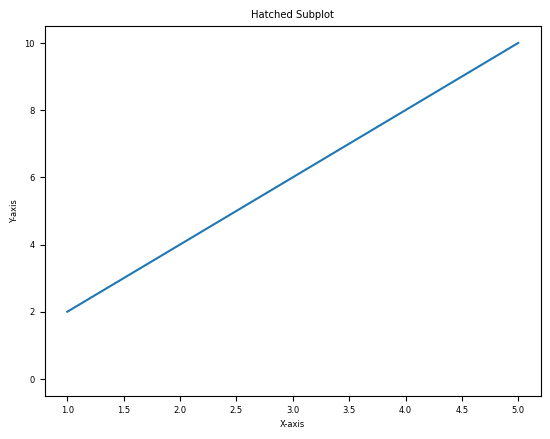

In [123]:
import matplotlib.pyplot as plt

# Create a new figure and a set of subplots
fig, ax = plt.subplots()

# Create some data to plot
x = [1, 2, 3, 4, 5]
y = [2, 4, 6, 8, 10]

# Plot the data
ax.plot(x, y)

# Add a hatch to the subplot
ax.fill_between(x, y, hatch='/', color='none')

# Set the title and labels for the plot
ax.set_title('Hatched Subplot')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

(0.0, 1.0)

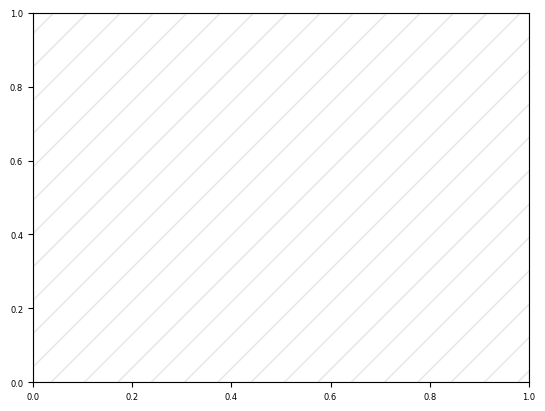